# 4. Ragas Evaluation

Ragas is a framework that helps you evaluate your Retrieval Augmented Generation (RAG) pipelines.  

RAGAS evaluate the following metrics:

**Answer Relevancy**
- What It Measures: This metric assesses how pertinent your RAG model’s answer is to the given prompt. You’re looking for answers that hit the nail on the head, not ones that beat around the bush.
- Scoring: It’s a game of precision, with scores ranging from 0 to 1. Higher scores mean your model’s answers are right on target.
- Example:  
    Question: What causes seasonal changes?  
    Low relevance answer: The Earth’s climate varies throughout the year  
    High relevance answer: Seasonal changes are caused by the tilt of the Earth’s axis and its orbit around the Sun.
    
**Faithfulness**
- What It Measures: Here, you’re checking if the answers stick to the facts provided in the context. It’s all about staying true to the source.
- Scoring: Also on a scale of 0 to 1. Higher values mean your answer is a faithful representation of the context.
- Example:  
    Question: What is the significance of the Apollo 11 mission?  
    Context: Apollo 11 was the first manned mission to land on the Moon in 1969.  
    High faithfulness answer: Apollo 11 is significant as it was the first mission to bring humans to the Moon.  
    Low faithfulness answer: Apollo 11 was significant for its study of Mars.  
    
**Context Precision**
- What It Measures: This one’s about whether your model ranks all the relevant bits of information at the top. You want the most important pieces front and center.
- Scoring: Once again, it’s a 0 to 1 scale. Higher scores indicate your model is doing a great job at prioritizing the right context.
- Example:  
    Question: What are the health benefits of regular exercise?  
    High precision: The model ranks contexts discussing cardiovascular health, mental well-being, and muscle   strength at the top.
    Low precision: The model prioritizes contexts unrelated to health, such as the history of sports.  
    
**Answer Correctness**
- What It Measures: This is about straight-up accuracy – how well does the answer align with the ground truth?
- Scoring: Judged on a 0 to 1 scale, where higher scores signal a bullseye match with the ground truth.
- Example:  
    Ground Truth: Photosynthesis in plants primarily occurs in the chloroplasts.  
    High answer correctness: Photosynthesis takes place in the chloroplasts of plant cells.  
    Low answer correctness: Photosynthesis occurs in the mitochondria of plants.  
    
Each metric provides a different lens to view your model’s performance, from how relevant and faithful its answers are, to how precise it is with contexts and how correct its answers align with known truths.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain_openai import ChatOpenAI
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain_anthropic import ChatAnthropic
from langchain_mistralai.chat_models import ChatMistralAI
from langchain.document_loaders import PyPDFLoader
from datasets import Dataset
import pandas as pd
from tqdm import tqdm
import json
import ragas
from ragas.metrics import (
    answer_relevancy, 
    faithfulness,
    context_recall,
    context_precision,
    context_relevancy,
    answer_correctness,
    answer_similarity
)

/home/juan/anaconda3/envs/siac/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set API, embedding and vector database path

In [16]:
# List of models tested:
# gpt-3.5-turbo
# gpt-4-turbo
# gpt-4o
# claude-3-haiku-20240307
# claude-3-sonnet-20240229
# claude-3-opus-20240229
# open-mistral-7b
# open-mixtral-8x7b
# open-mixtral-8x22b
# llama-7b-chat
# llama-13b-chat
# llama-70b-chat
# llama3-8b
# llama3-70b
# gemma-7b
# gemma-2b

# Model to evaluate
llm_name = "llama-7b-chat"

# Evaluation data mode
mode = "manual" # or "synthetic"

embedding_dimensions = 3072 #1536  # 3072

# outputdir
output_dirname = f"/datasets2/Dropbox/Projects/SACI/paper1/results_{mode}_eval"

# API key 
if "gpt" in llm_name:
    client = os.environ['OPENAI_API_KEY']
elif "claude" in llm_name:
    client = os.environ['ANTHROPIC_API_KEY']
elif "mistral" in llm_name or "mixtral" in llm_name:
    client = os.environ['MISTRAL_API_KEY']
elif "llama" in llm_name or "gemma" in llm_name:
    client = os.environ['LLAMA_API_KEY']
else:
    print("INVALID MODEL!")
    
print(f"Model selected for evaluation: {llm_name}")
print(f"Evaluation mode: {mode}")

# OpenAI embedding model
embedding_model = OpenAIEmbeddings(model="text-embedding-3-large", dimensions=embedding_dimensions)

# Model for RAGAs
llm_name_for_ragas = "gpt-4o"
if "gpt" in llm_name_for_ragas:
    llm_for_ragas = ChatOpenAI(model_name=llm_name_for_ragas, temperature=0) 
elif "claude" in llm_name_for_ragas:    
    llm_for_ragas = ChatAnthropic(model_name=llm_name_for_ragas, api_key=client, temperature=0)
    
print(f"Model selected as RAGAs intelligence: {llm_name_for_ragas}")

Model selected for evaluation: llama-7b-chat
Evaluation mode: manual
Model selected as RAGAs intelligence: gpt-4o


In [4]:
# Vector dataset
vectordb_directory = f'vector_database_chspark_{embedding_dimensions}'

# Create chroma db from existing vectordb_directory
vectordb = Chroma(
    embedding_function=embedding_model,
    persist_directory=vectordb_directory
)

print(f"Load {vectordb._collection.count()} collections from vector database")


Load 243 collections from vector database


In [11]:
template = """\
You are an assistant and you have to answer the questions that are asked of you. 
If the question is about the vehicle, use the provided car manual information to answer the question at the end. 
If you don’t know the answer even with the car manual provided say "I am sorry, I did not find the answer in the car manual"
Don’t try to make up an answer.
Respond in the most attentive way possible. Use a maximum of three sentences. 
Keep the answer as concise as possible. 
Context: {context}
Question: {question}
Helpful Answer:
"""

# create prompt template object
qa_chain_prompt = PromptTemplate.from_template(template)

if "gpt" in llm_name:
    llm = ChatOpenAI(model_name=llm_name, temperature=0) 
elif "claude" in llm_name:    
    llm = ChatAnthropic(model_name=llm_name, api_key=client, temperature=0)
elif "mistral" in llm_name or "mixtral" in llm_name:
    llm = ChatMistralAI(model=llm_name, api_key=client, temperature=0)
elif "llama" in llm_name or "gemma" in llm_name:
    llm = ChatOpenAI(model_name=llm_name, api_key=client, temperature=0,
                     base_url="https://api.llama-api.com") 

print(f"Using Model: {llm.model_name}")

# QA RAG object
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    return_source_documents=True,
    chain_type_kwargs={"prompt": qa_chain_prompt}
)

Using Model: llama-7b-chat


## Load the evaluation dataset

In [12]:
eval_dataset = Dataset.from_csv(f"{mode}_eval_dataset_spark.csv")
eval_dataset

Generating train split: 20 examples [00:00, 710.74 examples/s]


Dataset({
    features: ['question', 'context', 'ground_truth'],
    num_rows: 20
})

## Create responses dataset for evaluation

In [20]:
def create_responses_dataset(rag_pipeline, eval_dataset):
    """
    Creates a RAG (Retrieval-Augmented Generation) dataset for evaluation.

    This function processes an evaluation dataset using a RAG pipeline, generating answers to questions
    and collecting the corresponding context documents. The resulting data is formatted into a DataFrame
    and then converted to a Hugging Face Dataset for further evaluation.

    Args:
        rag_pipeline (callable): A function or model pipeline that takes a query dictionary with a "query" key 
                                 and returns a dictionary with "result" (the generated answer) and "source_documents" 
                                 (the context documents used for generation).
        eval_dataset (list of dict): A list of dictionaries, where each dictionary represents a row with at least 
                                     the keys "question" and "ground_truth".

    Returns:
        Dataset: A Hugging Face Dataset containing the processed data, with columns for questions, answers, 
                 contexts, and ground truths.

    Example:
        rag_pipeline = lambda x: {"result": "This is an answer", "source_documents": [{"page_content": "Some context"}]}
        eval_dataset = [{"question": "What is the capital of France?", "ground_truth": "Paris"}]
        rag_eval_dataset = create_ragas_dataset(rag_pipeline, eval_dataset)
    """
    rag_dataset = []
    for row in tqdm(eval_dataset):
        answer = rag_pipeline.invoke({"query" : row["question"]})
        rag_dataset.append({
            "question" : row["question"],
            "answer" : answer["result"],
            "contexts" : [context.page_content for context in answer["source_documents"]],
            "ground_truth" : row["ground_truth"]
        })
    rag_df = pd.DataFrame(rag_dataset)
    rag_eval_dataset = Dataset.from_pandas(rag_df)
    return rag_eval_dataset


def evaluate_responses_dataset(responses_dataset, embedding_model, llm):
    """
    Evaluates a RAG (Retrieval-Augmented Generation) dataset using specified metrics.

    This function takes a RAG dataset and evaluates it using a set of predefined metrics,
    returning the evaluation results. The evaluation involves assessing various aspects such
    as context precision, faithfulness, answer relevancy, context recall, context relevancy,
    answer correctness, and answer similarity.

    Args:
        ragas_dataset (Dataset): A Hugging Face Dataset containing the processed RAG data, 
                                 with columns for questions, answers, contexts, and ground truths.
        llm (langchain model): A langchain model used for internal RAGAs processing

    Returns:
        dict: A dictionary containing the evaluation results for each metric.

    Example:
        ragas_dataset = create_ragas_dataset(rag_pipeline, eval_dataset)
        evaluation_results = evaluate_ragas_dataset(ragas_dataset)
    """
    result = ragas.evaluate(
        dataset=responses_dataset,
        llm=llm,
        embeddings=embedding_model,
        metrics=[
            context_precision,
            faithfulness,
            answer_relevancy,
            context_recall,
            context_relevancy,
            answer_correctness,
            answer_similarity
        ],
    )
    return result

## Get responses dataset
**Beware!!**   
This is an expensive operation because it uses the llm for responding all the questions in the dataset.

In [14]:
# Run the eval dataset through the RAG QA and compile the answers
# Return a Hugging Face dataset containing the questions, the answers, the contexts and the groundtruths
basic_qa_responses = create_responses_dataset(qa_chain, eval_dataset)

  0%|                                                                                                  | 0/20 [00:00<?, ?it/s]/home/juan/anaconda3/envs/siac/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(
100%|█████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:06<00:00, 15.31s/it]


## Save the results dataset to a csv file

In [17]:
output_dir = f"{output_dirname}/{llm_name}"
os.makedirs(output_dir, exist_ok=True)

basic_qa_responses.to_csv(os.path.join(output_dir, "basic_qa_ragas_dataset_spark.csv"))

Creating CSV from Arrow format: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 108.48ba/s]


110783

In [18]:
basic_qa_responses[0]

{'question': 'How many safety belts does this car has?',
 'answer': 'According to the provided car manual, the car is equipped with three-point safety belts in the front seats and three-point safety belts in the outboard rear seating positions, as well as a center seat equipped with a lap safety belt.',
 'contexts': ['2–6  SEATS AND OCCUPANT PROTECTION SYSTEMS\nAlways fasten your safety belts correctly:\n1. Close and lock the doors.2. Make sure seatback is upright.\n3. Pick up the safety belt latch plate and\nuse it to pull the belt across your body.\nMake sure the belt is not twisted. If thesafety belt locks as you are pulling it\nout, allow it to rewind into the retrac-\ntor. Pull the safety belt out again to acomfortable and secure length.\n4. Position the shoulder belt midway over\nthe shoulder and across the chest.\nNever place the shoulder belt acrossthe neck. This assures that in the caseFRONT SEAT OCCUPANTS\nEach front seat is equipped with adjust-able seat and seatback with he

## Evaluate responses with Ragas
**Beware!!**   
This is an expensive operation because it uses the llm_for_ragas for comparing the responses with the groundtruth

In [19]:
basic_qa_result = evaluate_responses_dataset(basic_qa_responses, embedding_model, llm_for_ragas)

Evaluating: 100%|███████████████████████████████████████████████████████████████████████████| 140/140 [01:08<00:00,  2.05it/s]


In [21]:
basic_qa_result

{'context_precision': 0.8083, 'faithfulness': 0.9250, 'answer_relevancy': 0.7686, 'context_recall': 0.8305, 'context_relevancy': 0.0500, 'answer_correctness': 0.4917, 'answer_similarity': 0.7356}

In [27]:
basic_qa_result2 = basic_qa_result.copy()
basic_qa_result2['model'] = llm_name
basic_qa_result2['method'] = "Basic"

# rename the keys
key_mapping = {
    'context_precision': 'Context Precision',
    'faithfulness': 'Faithfulness',
    'answer_relevancy': 'Answer Relevancy',
    'context_recall': 'Context Recall',
    'context_relevancy': 'Context Relevancy',
    'answer_correctness': 'Answer Correctness',
    'answer_similarity': 'Answer Similarity',
    'model': 'Model',
    'method': 'Method'
}

# Creating a new dictionary with updated keys
basic_qa_result3 = {key_mapping[key]: value for key, value in basic_qa_result2.items()}

print(basic_qa_result3)

{'Context Precision': 0.808333333280625, 'Faithfulness': 0.925, 'Answer Relevancy': 0.7686496202549865, 'Context Recall': 0.8304738562091505, 'Context Relevancy': 0.04998298265645037, 'Answer Correctness': 0.4916794624489406, 'Answer Similarity': 0.7355675899980934, 'Model': 'llama-7b-chat', 'Method': 'Basic'}


## Save the metrics to a file

In [28]:
def append_dict_to_file(file_path, new_dict):
    # Check if the file exists
    if os.path.exists(file_path):
        # Read the existing list from the file
        with open(file_path, 'r') as file:
            data = json.load(file)
    else:
        # If the file does not exist, start with an empty list
        data = []

    # Append the new dictionary to the list
    data.append(new_dict)

    # Write the updated list back to the file
    with open(file_path, 'w') as file:
        json.dump(data, file, indent=4)

In [33]:
output_dir = f"{output_dirname}"
os.makedirs(output_dir, exist_ok=True)

append_dict_to_file(os.path.join(output_dir, f"results_{mode}.json"), basic_qa_result3)

In [34]:
def plot_metrics_with_values(metrics_dict, title='RAG Metrics'):
    """
    Plots a bar chart for metrics contained in a dictionary and annotates the values on the bars.

    Args:
    metrics_dict (dict): A dictionary with metric names as keys and values as metric scores.
    title (str): The title of the plot.
    """
    names = list(metrics_dict.keys())
    values = list(metrics_dict.values())

    plt.figure(figsize=(10, 6))
    plt.grid(zorder=0)
    bars = plt.barh(names, values, color='blue', zorder=3)

    # Adding the values on top of the bars
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01,  # x-position
                 bar.get_y() + bar.get_height() / 2,  # y-position
                 f'{width:.4f}',  # value
                 va='center',
                 zorder=4)

    plt.xlabel('Score')
    plt.title(title)
    plt.xlim(0, 1)  # Setting the x-axis limit to be from 0 to 1
    plt.show()

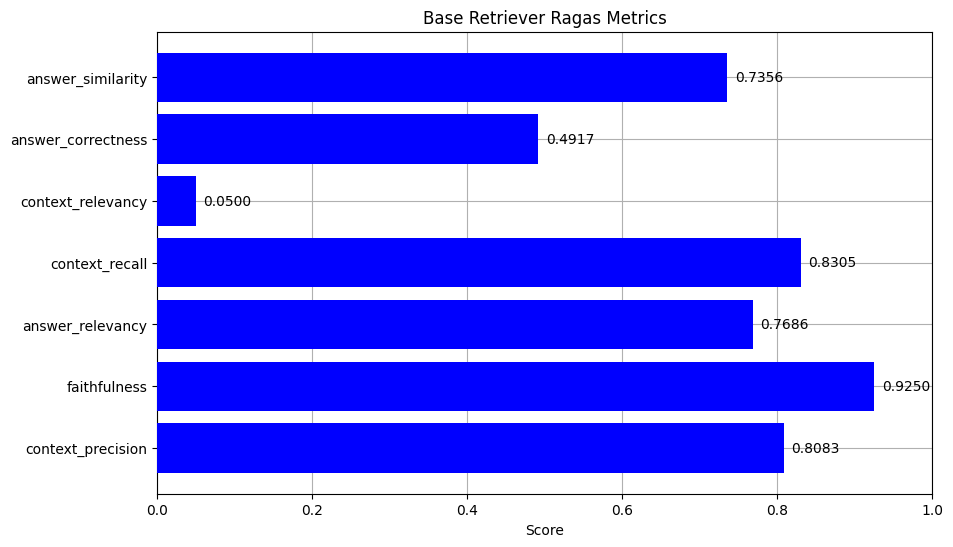

In [36]:
plot_metrics_with_values(basic_qa_result, "Base Retriever Ragas Metrics")

# Experiment with other Retrievers

Now we can test how changing our Retriever impacts our RAG evaluation!
We’ll build this simple qa_chain factory to create standardized qa_chains where the only different component will be the retriever.

In [37]:
def create_qa_chain(retriever, llm):
    """
    Creates a question-answering (QA) chain using a language model and a document retriever.

    This function initializes a `RetrievalQA` object, designed to perform question-answering tasks using a language model (LLM) 
    and a document retriever. The `RetrievalQA` object will also return the source documents used to generate the answers.

    Args:
        retriever: An object responsible for retrieving relevant documents based on the input questions.
        llm: A language model used for generating answers. This should be defined before calling this function.

    Returns:
        RetrievalQA: An object that can be used to perform QA tasks and retrieve source documents.

    Example:
        retriever = SomeRetriever()  # Initialize your retriever here
        llm = SomeLanguageModel()    # Initialize your language model here
        qa_chain = create_qa_chain(retriever, llm)
        response = qa_chain({"query": "What is the capital of France?"})
        print(response)
    """
    # Commented out line indicates a specific LLM initialization, which might have been done previously but is omitted here.
    # primary_qa_llm = ChatOpenAI(model_name="gpt-3.5-turbo-16k", temperature=0)

    # Creates a `RetrievalQA` object using the `from_chain_type` method.
    # The `llm` parameter should be a variable or argument representing the language model.
    # The `retriever` parameter is an object that handles retrieving relevant documents for the questions.
    # `return_source_documents=True` means the `RetrievalQA` object will return the source documents used for answering questions.
    created_qa_chain = RetrievalQA.from_chain_type(
        llm,
        retriever=retriever,
        return_source_documents=True
    )

    # Returns the created `RetrievalQA` object. This object can be used for QA tasks and inspecting the source documents
    # for the provided answers.
    return created_qa_chain


### Load PDF

In [39]:
loader = PyPDFLoader('chevrolet-spark.pdf')

# load pdf pages
pages = loader.load()
print(f"The document has {len(pages)} pages")

# RecursiveCharacterTextSplitter with overlap
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 2000,  # chunk size in characters
    chunk_overlap = 150 # Caracteres de solapamiento entre segmentos consecutivos.
)

The document has 204 pages


## Parent Document Retriever
One of the easier ways we can imagine improving a retriever is to embed our documents into small chunks, and then retrieve a significant amount of additional context that “surrounds” the found context.

The basic outline of this retrieval method is as follows:

1. Obtain User Question
2. Retrieve child documents using Dense Vector Retrieval
3. Merge the child documents based on their parents. If they have the same parents – they become merged.
4. Replace the child documents with their respective parent documents from an in-memory-store.
5. Use the parent documents to augment generation.

### Embedding and Vectorstore

In [40]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore

# Creates a `RecursiveCharacterTextSplitter` object to split text into more manageable segments of 2000 characters.
# This class is useful for processing large amounts of text that need to be divided into smaller parts for analysis or storage.
parent_splitter = RecursiveCharacterTextSplitter(chunk_size=2000)

# Creates another `RecursiveCharacterTextSplitter` object, this time with a smaller segment size of 400 characters.
# This can be used for more granular subdivision of the text, possibly for tasks that require higher precision in text processing.
child_splitter = RecursiveCharacterTextSplitter(chunk_size=400)

vectorstore = Chroma(collection_name='split_parents', 
                     embedding_function=OpenAIEmbeddings())
store = InMemoryStore()

In [41]:
# Creates an instance of `ParentDocumentRetriever`. This class is used to retrieve documents that are "parents" of a given document.
# `vectorstore` is the vector store where the document embeddings are stored.
# `child_splitter` is the object used to split child documents into smaller fragments.
# `parent_splitter` is the object used to split parent documents into larger fragments.
parent_document_retriever = ParentDocumentRetriever(
    vectorstore=vectorstore,
    docstore=store,
    child_splitter=child_splitter,
    parent_splitter=parent_splitter,
)

# Adds documents to the `ParentDocumentRetriever` so they can be processed and used in retrieval operations.
# `pages` is a list or set of documents that will serve as the basis for future retrieval and analysis operations.
parent_document_retriever.add_documents(pages)  # `base_docs=pages` indicates the base documents that will be added.

# Prints the number of documents currently stored in the collection within `vectorstore`.
# This is useful for verifying that the documents have been added correctly and for understanding the scale of the data store.
print(vectorstore._collection.count())


1321


### Let's try the new QA Chain

In [42]:
parent_document_retriever_qa_chain = create_qa_chain(parent_document_retriever, llm)

In [43]:
# Utiliza la cadena de consultas de preguntas y respuestas (QA Chain) para hacer una consulta específica sobre el tipo de gasolina adecuado para un vehículo.
# El método se llama con un diccionario que contiene una clave 'query' y el valor de la pregunta que deseas realizar.
# 'Que tipo de gasolina es apta para nuestro vehiculo' es la pregunta formulada.
# La respuesta a la consulta se obtiene accediendo a la clave 'result' del diccionario devuelto por el método.
result = parent_document_retriever_qa_chain({'query' : 'What kind of gas does the vehicule use?'})['result']

# Imprime el resultado obtenido.
print(result)

According to the provided context, the vehicle uses fuel with an Octane rating of 87 or higher.


## Evaluate the parent document retriever
**Beware!!**   
This is an expensive operation because it uses the llm for responding all the questions in the dataset.

In [44]:
# Evaluate the dataset using the parent document retriever
pdr_qa_ragas_dataset = create_responses_dataset(parent_document_retriever_qa_chain, eval_dataset)


100%|█████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:32<00:00, 16.60s/it]


### Save responses dataset to CSV

In [45]:
output_dir = f"{output_dirname}/{llm_name}"
os.makedirs(output_dir, exist_ok=True)

pdr_qa_ragas_dataset.to_csv(os.path.join(output_dir, 'pdr_qa_ragas_dataset_spark.csv'))

Creating CSV from Arrow format: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 182.15ba/s]


84093

## Evaluate responses with Ragas
**Beware!!**   
This is an expensive operation because it uses the llm_for_ragas for comparing the responses with the groundtruth

In [46]:
pdr_qa_result = evaluate_responses_dataset(pdr_qa_ragas_dataset, embedding_model, llm_for_ragas)

Evaluating: 100%|███████████████████████████████████████████████████████████████████████████| 140/140 [01:08<00:00,  2.05it/s]


In [47]:
pdr_qa_result

{'context_precision': 0.8042, 'faithfulness': 0.9615, 'answer_relevancy': 0.8033, 'context_recall': 0.8037, 'context_relevancy': 0.0593, 'answer_correctness': 0.5375, 'answer_similarity': 0.7648}

In [48]:
pdr_qa_result2 = pdr_qa_result.copy()
pdr_qa_result2['model'] = llm_name
pdr_qa_result2['method'] = "PDR"

# Creating a new dictionary with updated keys
pdr_qa_result3 = {key_mapping[key]: value for key, value in pdr_qa_result2.items()}

print(pdr_qa_result3)

{'Context Precision': 0.8041666666060416, 'Faithfulness': 0.9615277777777779, 'Answer Relevancy': 0.8033075023049678, 'Context Recall': 0.8037393162393162, 'Context Relevancy': 0.059301555476997656, 'Answer Correctness': 0.5374682278020131, 'Answer Similarity': 0.7648068689115328, 'Model': 'llama-7b-chat', 'Method': 'PDR'}


### Save metrics

In [51]:
output_dir = f"{output_dirname}"
os.makedirs(output_dir, exist_ok=True)

append_dict_to_file(os.path.join(output_dir, f"results_{mode}.json"), pdr_qa_result3)

## Ensemble Retrievel
Next, let’s look at ensemble retrieval.

The basic idea is as follows:

1. Obtain User Question
2. Hit the Retriever Pair  
    -Retrieve Documents with BM25 Sparse Vector Retrieval  
    -Retrieve Documents with Dense Vector Retrieval Method
3. Collect and “fuse” the retrieved docs based on their weighting using the Reciprocal Rank Fusion algorithm into a single ranked list.
4. Use those documents to augment our generation.

In [52]:
from langchain.retrievers import BM25Retriever, EnsembleRetriever

text_splitter = RecursiveCharacterTextSplitter()
docs = text_splitter.split_documents(pages)

# Create a BM25Retriever object from the split documents.
bm25_retriever = BM25Retriever.from_documents(docs)
# Set the number of documents toretrieve per query to 2.
bm25_retriever.k = 2

# Create a vectorstore from the documents using OpenAIEmbeddings.
vectorstore = Chroma.from_documents(docs, embedding_model)
# Convert the vectorstore into a document retriever, specifying that it should retrieve the 2 most relevant documents per query.
chroma_retriever = vectorstore.as_retriever(search_kwargs={'k': 2})

# Create an EnsembleRetriever that combines the results of BM25Retriever and ChromaRetriever.
# Equal weights (0.5 each) are assigned to balance the influence of both retrievers in the final results.
ensemble_retriever = EnsembleRetriever(retrievers=[bm25_retriever, chroma_retriever], weights=[0.5, 0.5])


In [53]:
# Create qa_chain
ensemble_retriever_qa_chain = create_qa_chain(ensemble_retriever, llm)

### Try the ensemble retriever with a question

In [54]:
ensemble_retriever_qa_chain({'query' : 'Tell me about the motor'})['result']

'According to the Technical Information section of the warranty and service booklet, the motor specifications for your Chevrolet Spark are as follows:\n\n* Type: 4-cylinder/in-line\n* Displacement (cc): 995\n* Bore x stroke (mm): 68.5 x 67.5\n* Compression ratio: 9.3 ± 0.3 : 1\n* Max. Power (kW/rpm): 45.0/5400\n* Max. Tor'

### Get responses dataset
**Beware!!**   
This is an expensive operation because it uses the llm for responding all the questions in the dataset.

In [55]:
ensemble_qa_ragas_dataset = create_responses_dataset(ensemble_retriever_qa_chain, eval_dataset)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:11<00:00, 15.56s/it]


### Save results dataset to CSV

In [56]:
output_dir = f"{output_dirname}/{llm_name}"
os.makedirs(output_dir, exist_ok=True)

ensemble_qa_ragas_dataset.to_csv(os.path.join(output_dir, 'ensemble_qa_ragas_dataset_spark.csv'))

Creating CSV from Arrow format: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 193.67ba/s]


111418

## Evaluate responses with Ragas
**Beware!!**   
This is an expensive operation because it uses the llm_for_ragas for comparing the responses with the groundtruth

In [57]:
ensemble_qa_result = evaluate_responses_dataset(ensemble_qa_ragas_dataset, embedding_model, llm_for_ragas)

Evaluating: 100%|███████████████████████████████████████████████████████████████████████████| 140/140 [01:02<00:00,  2.25it/s]


In [58]:
ensemble_qa_result

{'context_precision': 0.5125, 'faithfulness': 0.9165, 'answer_relevancy': 0.7118, 'context_recall': 0.7372, 'context_relevancy': 0.0364, 'answer_correctness': 0.4457, 'answer_similarity': 0.7319}

In [59]:
ensemble_qa_result2 = ensemble_qa_result.copy()
ensemble_qa_result2['model'] = llm_name
ensemble_qa_result2['method'] = "Ensemble"

# Updated the keys' names
ensemble_qa_result3 = {key_mapping[key]: value for key, value in ensemble_qa_result2.items()}

print(ensemble_qa_result3)

{'Context Precision': 0.5124999999625001, 'Faithfulness': 0.9164682539682539, 'Answer Relevancy': 0.7117681594522285, 'Context Recall': 0.7372093023255814, 'Context Relevancy': 0.036420428984564886, 'Answer Correctness': 0.445655658939216, 'Answer Similarity': 0.7318533427732293, 'Model': 'llama-7b-chat', 'Method': 'Ensemble'}


### Save metrics

In [60]:
output_dir = f"{output_dirname}"
os.makedirs(output_dir, exist_ok=True)

append_dict_to_file(os.path.join(output_dir, f"results_{mode}.json"), ensemble_qa_result2)

# Summary

In [61]:
basic_qa_result

{'context_precision': 0.8083, 'faithfulness': 0.9250, 'answer_relevancy': 0.7686, 'context_recall': 0.8305, 'context_relevancy': 0.0500, 'answer_correctness': 0.4917, 'answer_similarity': 0.7356}

In [62]:
pdr_qa_result

{'context_precision': 0.8042, 'faithfulness': 0.9615, 'answer_relevancy': 0.8033, 'context_recall': 0.8037, 'context_relevancy': 0.0593, 'answer_correctness': 0.5375, 'answer_similarity': 0.7648}

In [63]:
ensemble_qa_result

{'context_precision': 0.5125, 'faithfulness': 0.9165, 'answer_relevancy': 0.7118, 'context_recall': 0.7372, 'context_relevancy': 0.0364, 'answer_correctness': 0.4457, 'answer_similarity': 0.7319}

In [64]:
def plot_comparison_metrics(basic, pdr, ensemble, title='Comparison of QA Metrics',
                            filename="qa_metrics.png"):
    """
    Plots a comparison bar chart for three sets of QA metrics.

    Args:
    basic (dict): A dictionary with metric names and values for the basic QA result.
    pdr (dict): A dictionary with metric names and values for the pdr QA result.
    ensemble (dict): A dictionary with metric names and values for the ensemble QA result.
    title (str): The title of the plot.
    """
    metrics = list(basic.keys())
    basic_values = list(basic.values())
    pdr_values = list(pdr.values())
    ensemble_values = list(ensemble.values())

    bar_width = 0.2
    index = np.arange(len(metrics))

    plt.figure(figsize=(12, 8))
    plt.grid(zorder=0)
    
    bars_basic = plt.barh(index - bar_width, basic_values, bar_width, label='Basic', color='blue', zorder=3)
    bars_pdr = plt.barh(index, pdr_values, bar_width, label='PDR', color='green', zorder=3)
    bars_ensemble = plt.barh(index + bar_width, ensemble_values, bar_width, label='Ensemble', color='red', zorder=3)

    # Adding the values on top of the bars
    for bars in [bars_basic, bars_pdr, bars_ensemble]:
        for bar in bars:
            width = bar.get_width()
            plt.text(width + 0.01,  # x-position
                     bar.get_y() + bar.get_height() / 2,  # y-position
                     f'{width:.4f}',  # value
                     va='center',
                     zorder=4)

    plt.xlabel('Score')
    plt.title(title)
    plt.yticks(index, metrics)
    plt.xlim(0, 1.1)  # Setting the x-axis limit to be from 0 to 1
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    #plt.show()
    # Save the figure with high resolution
    plt.savefig(filename, dpi=300)


Saving plot to /datasets2/Dropbox/Projects/SACI/paper1/results_manual_eval/llama-7b-chat/qa_metrics.png


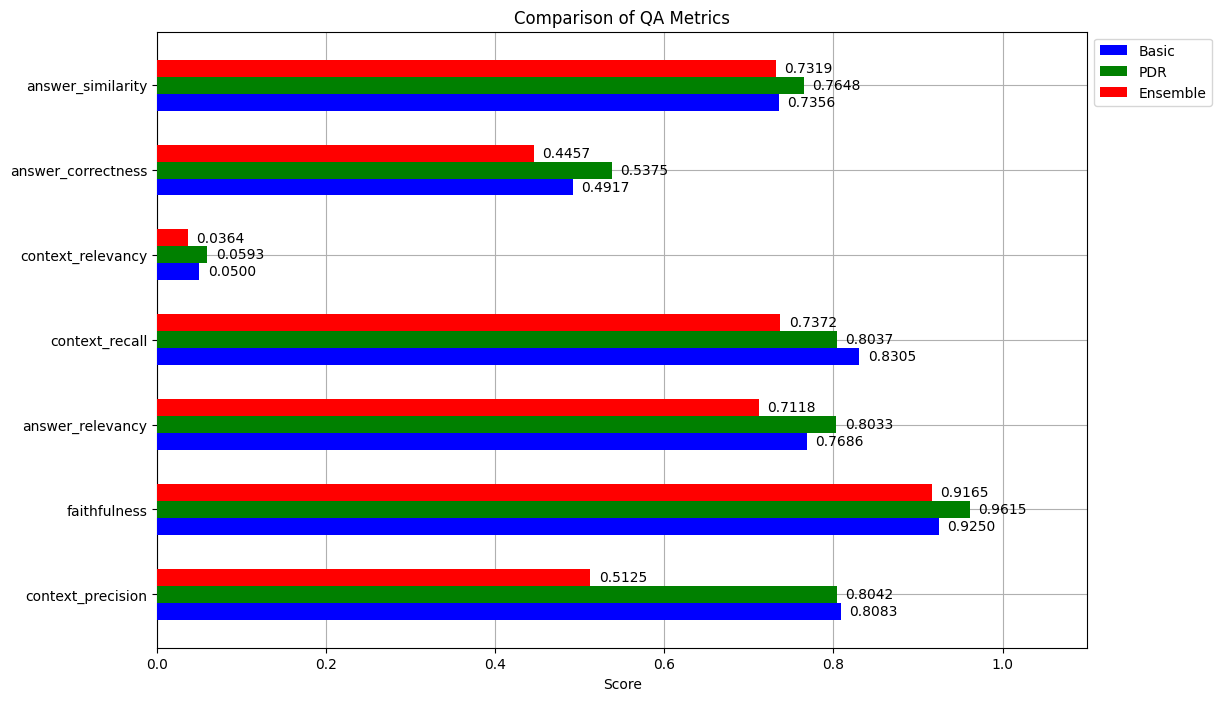

In [66]:
output_dir = f"{output_dirname}/{llm_name}"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "qa_metrics.png")
print(f"Saving plot to {output_path}")

# Plotting the comparison
plot_comparison_metrics(basic_qa_result, pdr_qa_result, ensemble_qa_result, filename=output_path)
